# Report on CrES experiments' results

Initial remarks: the models tested were `facebook/wav2vec2-large-slavic-voxpopuli-v2`, `facebook/wav2vec2-large-960h-lv60-self`, and `classla/wav2vec2-large-slavic-parlaspeech-hr`. HuBERT models were not yet implemented due to incompatibility issues, and with the unusual results we've been getting this hasn't yet gotten the focus it needs. In this notebook I analyze the last run of experiments that were performed on 2022-09-{01,02}, 20 runs in total.

Let's import the results file, calculate macroF1 scores and accuracies, and count total results instances for each model:

In [368]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex'])
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

test = pd.read_csv("007_test.csv")
dev = pd.read_csv("007_dev.csv")
train = pd.read_csv("007_train.csv")
df = pd.read_json("008_results_new_new_new.jsonl", lines=True)
labels = [
'happiness', 
'neutral', 
'sadness',
'fear', 
'anger', 
]
df["accuracy"] = df.apply(lambda row: accuracy_score(row["y_true"],
                                                     row["y_pred"],
                                                     ), axis=1)
df["macroF1"] = df.apply(lambda row: f1_score(row["y_true"],
                                              row["y_pred"], average="macro", labels=labels), axis=1)
df.model_name_or_path.value_counts()


facebook/wav2vec2-large-slavic-voxpopuli-v2     40
facebook/wav2vec2-large-960h-lv60-self          40
classla/wav2vec2-large-slavic-parlaspeech-hr    40
Name: model_name_or_path, dtype: int64

The last result has been obtained at:

In [369]:
df.time.dropna().max()

'2022-09-02 03:19:48.489589'

The next cell joins speaker ids and utterance ids to the table of results, which we can use later on for examining per speaker performance.

In [370]:
ids = []
sp_ids = []
for i, row in df.iterrows():
    if "test" in row["split"] :
        ids.append(
            test.utterance_id.tolist()
        )
        sp_ids.append(
            test.speaker_id.tolist()
        )
    else:
        ids.append(
            dev.utterance_id.tolist()
        )
        sp_ids.append(
            dev.speaker_id.tolist()
        )
df["utterance_ids"] = ids
df["speaker_ids"] = sp_ids
for i, row in df.iterrows():
    assert len(row["utterance_ids"]) == len(row["y_pred"])

Let's examine the metrics, grouped by model and split. We can see that all models perform better on dev split if we look at macro F1. We can also see that all models produced non-identical results, this is a bigger problem for 'facebook/wav2vec2-large-slavic-voxpopuli-v2' than it is for 'classla/wav2vec2-large-slavic-parlaspeech-hr' or 'facebook/wav2vec2-large-960h-lv60-self'. In the latter two cases the duplicated predictions only started to appear after 10 runs, and after 20 runs they accumulate 1 and 3 duplicated predictions. For the voxpopuli model this is a problem encountered much sooner and with greater frequency.

In [371]:
def unique(l):
    return len(set([str(i) for i in l]))
st = df.groupby(["model_name_or_path", "split"]).agg(
    {"accuracy": ["mean", "std"],
     "macroF1": ["mean", "std"],
     "y_pred": ["count", unique]}
).style.bar(vmin=0.6, subset=[("accuracy", "mean"), ("macroF1", "mean")], cmap="Oranges")

st#.to_html("images/008_accuracies.html")

The following cells calculate average performance, grouped by speaker_id and model on the test split.

In [372]:
def get_per_speaker_error_rate(row):
    speakers = row["speaker_ids"]
    y_true = row["y_true"]
    y_pred = row["y_pred"]
    
    df = pd.DataFrame(data={
        "speaker": speakers,
        "y_true": y_true,
        "y_pred": y_pred
    })
    df["correct"] = df.y_true == df.y_pred
    import numpy as np
    return df.groupby("speaker").aggregate({"correct": "mean"  })

correct_breakdown = []

for i, row in df.iterrows():
    correct_breakdown.append(
        get_per_speaker_error_rate(row).correct.to_json()
    )
df["correct_ratio_breakdown"] = correct_breakdown

In [373]:
from ast import literal_eval
s = df[df.split == "test"].correct_ratio_breakdown.apply(literal_eval).apply(pd.Series)        
ndf = s.melt().rename(columns={
    "variable": "speaker",
    "value": "correct_ratio"
})
models = df[df.split=="test"].model_name_or_path.tolist()
new_models = [models[i] for j in range(s.columns.shape[0]) for i in range(s.shape[0])]
ndf["model_name_or_path"] = new_models

On the plot below we can see the percentage of correctly identified instances of individual speakers by different models, with black lines indicating standard deviation. 

For some speakers all models correctly predict their utterances, some speakers are barely correctly predicted by any model, and some speakers are better recognised by some models than others.

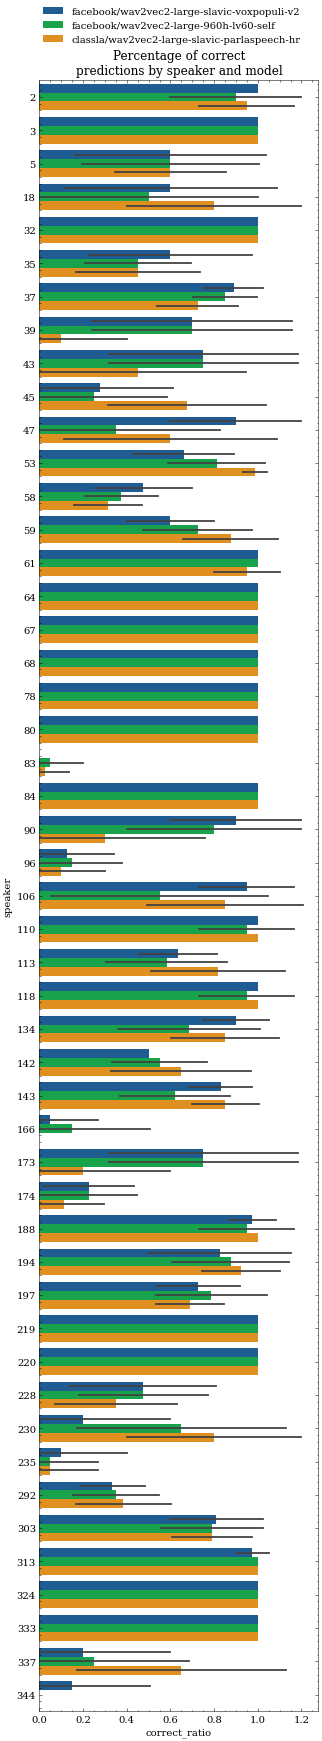

In [374]:
gb = ndf.groupby("speaker").aggregate({
    "correct_ratio": ["mean", "std"]
})
gb.index = gb.index.astype(int)
gb = gb.sort_index()

plt.figure(figsize=(5, 30))
sns.barplot(data = ndf, y = "speaker" , x = "correct_ratio", hue="model_name_or_path", ci="sd")
plt.title("Percentage of correct\npredictions by speaker and model")
plt.legend(loc=(0, 1.02))
plt.xlim((0, None))
# plt.tight_layout()
plt.savefig("images/008_speaker_and_model_correctness.pdf", dpi=200)
plt.show()

For sanity check let's see if we have any leakages between splits speakers:

In [375]:
test_speakers = set(test.speaker_id.tolist())
dev_speakers = set(dev.speaker_id.tolist())
train_speakers = set(train.speaker_id.tolist())

In [376]:
d = {"test_speakers": test_speakers,
     "dev_speakers": dev_speakers, 
     "train_speakers": train_speakers}

for first in d:
    for second in d:
        if first == second:
            continue
        print(f"{first} against {second}: {len(d[first].intersection(d[second]))} leaked")

test_speakers against dev_speakers: 0 leaked
test_speakers against train_speakers: 0 leaked
dev_speakers against test_speakers: 0 leaked
dev_speakers against train_speakers: 0 leaked
train_speakers against test_speakers: 0 leaked
train_speakers against dev_speakers: 0 leaked
